In [2]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
#from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGeneratorMod

from segment_anything import SamAutomaticMaskGenerator as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import functions as fnc
from automatic_mask_generator_mod2 import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGeneratorMod
import First_second_fnc as FS_fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import time
from skimage.morphology import binary_dilation
import json
from tqdm import tqdm
import pandas as pd


In [3]:
def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points


In [6]:
#load image
OutDIR='/DATA/vito/output/Ravi3_run2_dw4_cp512_3b_minarea/'

with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)
with open(OutDIR+'pre_para.json', 'r') as json_file:
    pre_para = json.load(json_file)

DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=5
resample_factor=init_para.get('resample_factor')

image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)

['/DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_ids.npy', '/DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_vis.npy', '/DATA/vito/data/Ravi/Ravi2_orthomosaic_02mm.png', '/DATA/vito/data/Ravi/label', '/DATA/vito/data/Ravi/Ravi4_orthomosaic_clip_02mm.tif', '/DATA/vito/data/Ravi/Ravi3_orthomosaic_clip_02mm.tif']
Ravi3_orthomosaic_clip_02mm.tif imported
Image size: (28382, 32563, 3)


In [9]:
id_mask=np.load(OutDIR+'Third/all_mask_third_pass_id.npy')
id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'target_size': image.shape[:-1][::-1],'method': 'nearest'})

x,y=np.mean(np.where((id_mask==2012)>0),axis=1)
x,y=int(x),int(y)

crop_size=1024
resample_factor=1/4
temp_id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'fxy': resample_factor,'method': 'nearest'})
label_area=np.sum(temp_id_mask==2012)
y,x=np.mean(np.where((temp_id_mask==2012)),axis=1)
x0,y0=int(x),int(y)
xmin,ymin=x0-crop_size/2,y0-crop_size/2
ji=xmin/crop_size
ii=ymin/crop_size
if ji<0:
    ji=0
if ii<0:
    ii=0

#prepare image
dw_image=fnc.resample_fnc(image,{'fxy': resample_factor})
pre_para={'Resample':{'fxy': resample_factor},'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
temp_image=fnc.preprocessing_roulette(image, pre_para)

In [10]:
gc.collect()
torch.cuda.empty_cache()
#setup SAM
MODEL_TYPE = "vit_h"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE, DataDIR)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=48,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(temp_image)
stack=np.sum([mask['segmentation'] for mask in masks], axis=0)
points=np.vstack([mask['point_coords'] for mask in masks])


Currently running on GPU
Model vit_h


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [11]:
def Guided_second_pass_SAM(cleaned_groups, min_pixel, min_radi, list_of_masks, predictor, crop_size, size_threshold=0.4,tm=0.5):
    ##problem--we are assuming that in each disconnected region there is only one object
    cleaned_groups_reseg=[]
    list_of_seed_points=[]
    for k in range(len(cleaned_groups)):
        stacked=np.stack([list_of_masks[i] for i in cleaned_groups[k]])
        mean_stacked=np.mean(stacked,axis=0)
        #std_stacked=np.std(stacked,axis=0)

        #separate high confidence region(high mean) and low
        labels=label(np.logical_and(mean_stacked<=tm,mean_stacked>0))
        regions=regionprops(labels)
        labels=label(np.logical_and(mean_stacked>tm,mean_stacked>0))
        regions_highmean=regionprops(labels)
        for region in regions_highmean:
            regions.append(region) 

        for props in regions:
            if (props.area>min_pixel):#apply minimum area to filter out mini residuals
                y0, x0 = props.centroid
                input_point = np.array([[x0,y0]])
                input_label = np.array([1])
                list_of_seed_points.append(props.centroid)
                partmasks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=True,)
                #best_idx=np.argmax(scores)#pick the mask with highest score
                partmasks=partmasks[np.argsort(scores)[::-1]]
                logits=logits[np.argsort(scores)[::-1]]
                scores=np.sort(scores)[::-1]
                pick=0
                while pick < len(partmasks):
                    mask_area = np.sum(partmasks[pick])
                    # if mask is very large compared to size of the image (credit:segment everygrain) modified from 0.1 to 0.4
                    if mask_area / (crop_size ** 2) <= size_threshold:
                        if fnc.area_radi(partmasks[pick], min_pixel, min_radi):
                            cleaned_groups_reseg.append({'mask':partmasks[pick],'score':scores[pick],'logit':logits[pick]})
                            break
                        else:
                            pick += 1
                    else:
                        pick += 1
                
    
    list_of_cleaned_groups_reseg_masks = [fnc.clean_mask(mask['mask'].astype('bool')) for mask in cleaned_groups_reseg]
    list_of_cleaned_groups_reseg_score=[mask['score'] for mask in cleaned_groups_reseg]
    return list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score,list_of_seed_points

In [12]:
#clear gpu ram
gc.collect()
torch.cuda.empty_cache()

#SAM segmentation
mask_generator = SamAutomaticMaskGeneratorMod(
    model=sam,
    points_per_side=48,
    pred_iou_thresh=0,
    stability_score_thresh=0.85,#iou by varying cutoff in binary conversion
    box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
    crop_n_layers=0,#cut into 2**n crops
    crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0,
    #min_mask_region_area=2000,
)
predictor = SamPredictor(sam)
predictor.set_image(temp_image)

with torch.no_grad():
    masks = mask_generator.generate(temp_image)
print('First pass SAM: ', len(masks),' mask(s) found')

#post processing
#filter output mask per point by select highest pred iou mask
masks=FS_fnc.filter_by_pred_iou_and_size_per_seedpoint(masks, crop_size)
print('Filtered by highest predicted iou per seed point, ', len(masks),' mask(s) remains')

list_of_pred_iou = [mask['predicted_iou'] for mask in masks]
list_of_masks = [fnc.clean_mask(mask['segmentation'].astype('bool')) for mask in masks]#remove small disconnected parts
no_area_after_cleaning=np.array([np.sum(mask)==0 for mask in list_of_masks])
area_radi=np.array([fnc.area_radi(mask, 500, 0) for mask in list_of_masks])
if np.any(no_area_after_cleaning):
    list_of_masks = [mask for mask, keep in zip(list_of_masks, ~no_area_after_cleaning) if keep]
    list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, ~no_area_after_cleaning) if keep]
if not np.all(area_radi):
    list_of_masks = [mask for mask, keep in zip(list_of_masks, area_radi) if keep]
    list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, area_radi) if keep]
#remove background/edge mask
flattened_rgb=np.sum(temp_image,axis=2)
not_background_mask=np.array([np.any(flattened_rgb[mask.astype('bool')]>0) for mask in list_of_masks])
if not np.all(not_background_mask):
    list_of_masks = [mask for mask, keep in zip(list_of_masks, not_background_mask) if keep]
    list_of_pred_iou = [mask for mask, keep in zip(list_of_pred_iou, not_background_mask) if keep]
    print('Background masks removed')

if len(list_of_masks)>0:
    #grouping overlaps
    list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms=[],[]
    group_overlap_area, unique_groups, list_overlap = FS_fnc.Groupping_masks(list_of_masks)
    unique_groups_thresholded = FS_fnc.filter_groupping_by_intersection(group_overlap_area,unique_groups, list_overlap)
    cleaned_groups, list_of_nooverlap_mask = FS_fnc.checking_remaining_ungroupped(list_of_masks, unique_groups_thresholded, masks)
    if cleaned_groups:
        list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score,list_of_seed_points = Guided_second_pass_SAM(cleaned_groups, 500, 0, list_of_masks, predictor, crop_size,0.2)
        if len(list_of_nooverlap_mask)>0:
            for m in list_of_nooverlap_mask:
                list_of_cleaned_groups_reseg_masks.append(list_of_masks[m].astype('bool'))
                list_of_cleaned_groups_reseg_score.append(list_of_pred_iou[m])
        list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
        print('Found ',len(list_of_cleaned_groups_reseg_score_nms), ' mask(s)/object(s) in the clip')
    else:
        list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = list_of_masks, list_of_pred_iou
        list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
        print(f'No groups were found, found {len(list_of_cleaned_groups_reseg_masks)} mask(s) from the first pass')
        print(f'{len(list_of_cleaned_groups_reseg_masks_nms)} left after nms filtering')

    #valid box
    #if len(list_of_cleaned_groups_reseg_masks_nms)>0:
        #keep = [fnc.mask_in_valid_box(mask,100, [3,3], [10,10]) for mask in list_of_cleaned_groups_reseg_masks_nms]
    #    keep = FS_fnc.mask_in_valid_box(list_of_cleaned_groups_reseg_masks_nms,100, [3,3], [10,10])
    #    list_of_cleaned_groups_reseg_masks_nms=[list_of_cleaned_groups_reseg_masks_nms[i] for i,k in enumerate(keep) if k]
    #    list_of_cleaned_groups_reseg_score_nms=[list_of_cleaned_groups_reseg_score_nms[i] for i,k in enumerate(keep) if k]
    #    print(f'{len(list_of_cleaned_groups_reseg_masks_nms)} left after filtering by valid box')

First pass SAM:  3846  mask(s) found
Filtered by highest predicted iou per seed point,  1841  mask(s) remains
Threshold: 1000 pixels, 981109 groups removed 
Overlap groups before filtering: 981182, after filtering: 73
Found  101  mask(s)/object(s) in the clip


In [13]:
points=build_point_grid(48)*1024

/tmp/ipykernel_1827360/1827909965.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


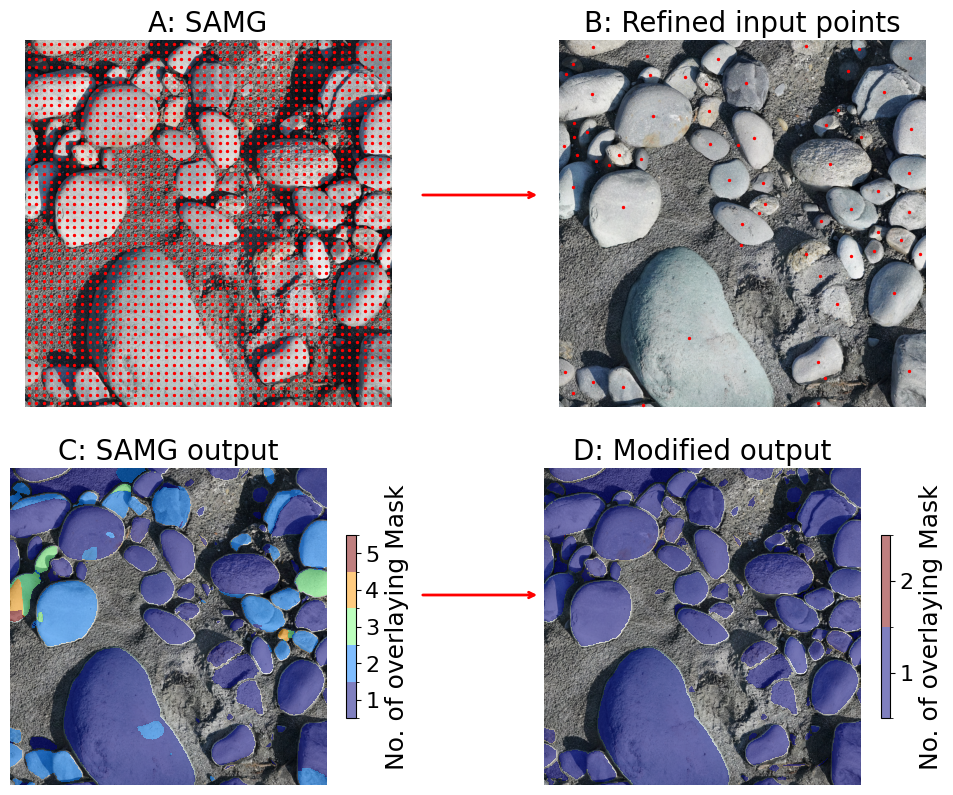

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming temp_image, points, list_of_seed_points, stack, stacked_modi, and fnc.show_mask_stack are defined
stacked_modi = np.sum(list_of_cleaned_groups_reseg_masks_nms, axis=0)
vmax = np.max([np.max(stack), np.max(stacked_modi)])
vmin = np.min([np.min(stack), np.min(stacked_modi)])

fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.35, 'hspace': 0.1})

# Plot A: Original SamAutomaticMaskGenerator
axes[0, 0].imshow(temp_image)
axes[0, 0].scatter(points[:, 0], points[:, 1], color='red', s=2)
axes[0, 0].set_title('A: SAMG', fontsize=20)
axes[0, 0].axis('off')

# Plot B: Refined seed points
list_of_seed_points = np.stack(list_of_seed_points)
axes[0, 1].imshow(temp_image)
axes[0, 1].scatter(list_of_seed_points[:, 1], list_of_seed_points[:, 0], color='red', s=2)
axes[0, 1].set_title('B: Refined input points', fontsize=20)
axes[0, 1].axis('off')

# Plot C: SamAutomaticMaskGenerator output
axes[1, 0].imshow(temp_image)
fnc.show_mask_stack(stack, axes[1, 0])
axes[1, 0].set_title('C: SAMG output', fontsize=20)
axes[1, 0].axis('off')

# Plot D: Modified output
axes[1, 1].imshow(temp_image)
fnc.show_mask_stack(stacked_modi, axes[1, 1])
axes[1, 1].set_title('D: Modified output', fontsize=20)
axes[1, 1].axis('off')

x_left = 0.3  
x_right = 0.45 
y_top = 0.6
y_bottom = 0.2 

plt.annotate("", xy=(x_right, y_top), xytext=(x_left+0.05, y_top),
             xycoords="figure fraction", textcoords="figure fraction",
             arrowprops=dict(arrowstyle="->", color="red", lw=2))

plt.annotate("", xy=(x_right, y_bottom), xytext=(x_left+0.05, y_bottom),
             xycoords="figure fraction", textcoords="figure fraction",
             arrowprops=dict(arrowstyle="->", color="red", lw=2))
plt.tight_layout()
plt.savefig('/DATA/vito/fig/improved_seed_point.png')
plt.show()


Text(0.5, 1.0, 'Modified output')

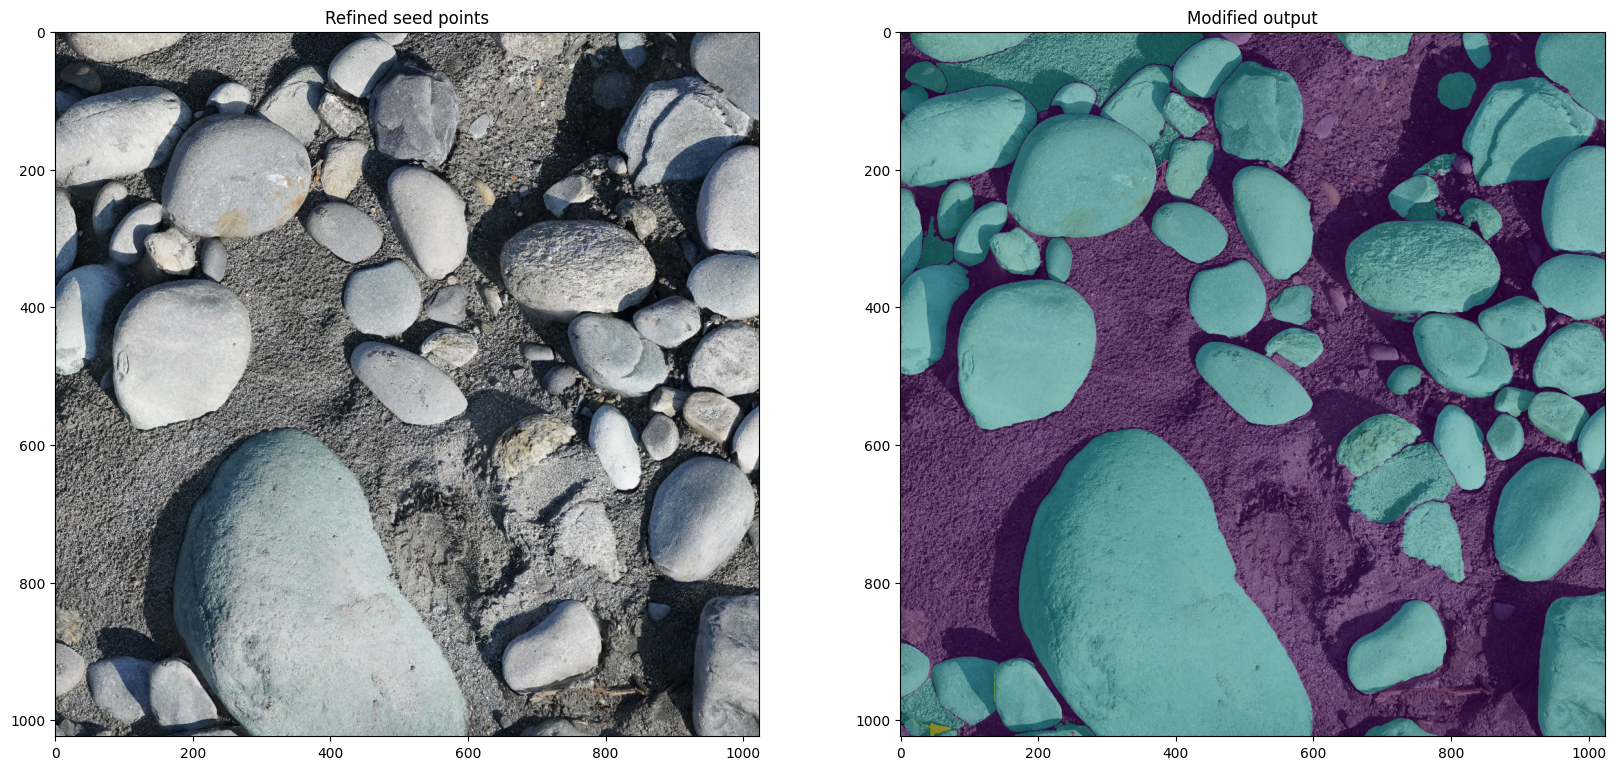

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(temp_image)
plt.title('Refined seed points')
plt.subplot(1,2,2)
plt.imshow(temp_image)
plt.imshow(np.sum(list_of_cleaned_groups_reseg_masks_nms,axis=0),alpha=0.5)
plt.title('Modified output')

In [5]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=48,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(temp_image)
stack=np.sum([mask['segmentation'] for mask in masks], axis=0)
points=np.vstack([mask['point_coords'] for mask in masks])

#points=build_point_grid(48)*1024

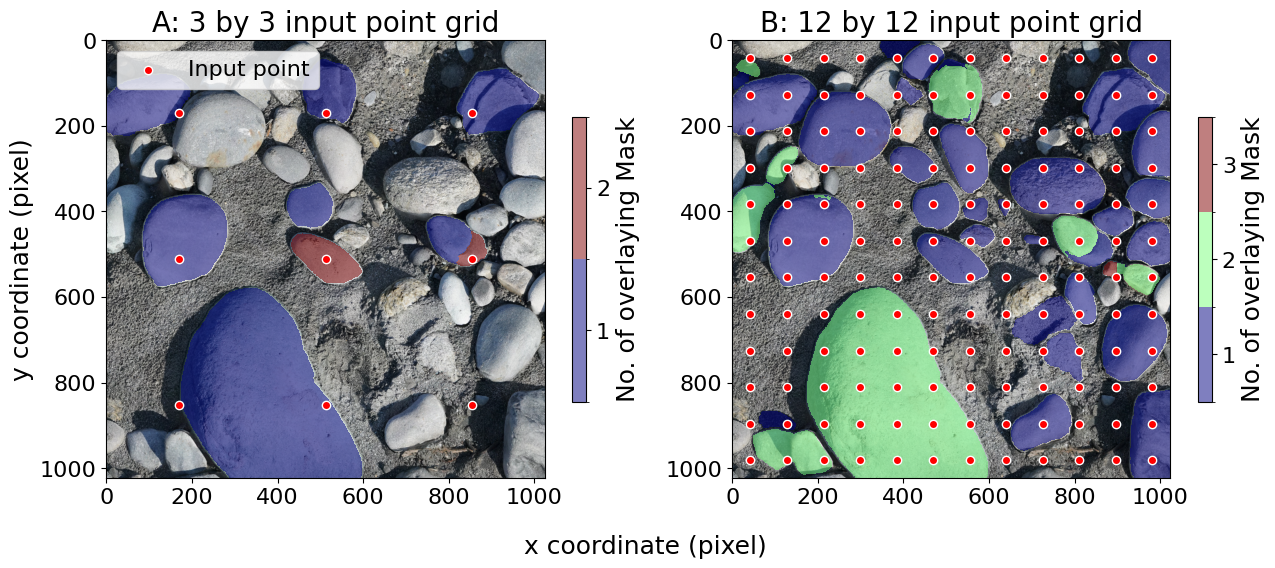

In [28]:
plt.figure(figsize=(13,6))

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=3,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(temp_image)
stack=np.sum([mask['segmentation'] for mask in masks], axis=0)
points=build_point_grid(3)*1024

plt.subplot(1,2,1)
plt.imshow(temp_image)
fnc.show_mask_stack(stack, plt.gca())

plt.scatter(points[:,0],points[:,1],color='red', edgecolor='white', label='Input point')
plt.title('A: 3 by 3 input point grid', fontsize=20)
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(temp_image)
stack=np.sum([mask['segmentation'] for mask in masks], axis=0)
points=build_point_grid(12)*1024

plt.subplot(1,2,2)
plt.imshow(temp_image)
fnc.show_mask_stack(stack, plt.gca())

plt.scatter(points[:,0],points[:,1],color='red', edgecolor='white')
plt.title('B: 12 by 12 input point grid', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlabel("x coordinate (pixel)", fontsize=18)
plt.figtext(0.5, 0.01, 'x coordinate (pixel)', ha='center', fontsize=18)
plt.tight_layout()
plt.savefig('/DATA/vito/fig/3x3grid')
plt.show()

In [38]:
input_point = np.array([[853, 512]])
input_point = np.array([[0, 400]])
input_label = np.array([1])

predictor = SamPredictor(sam)
predictor.set_image(temp_image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)


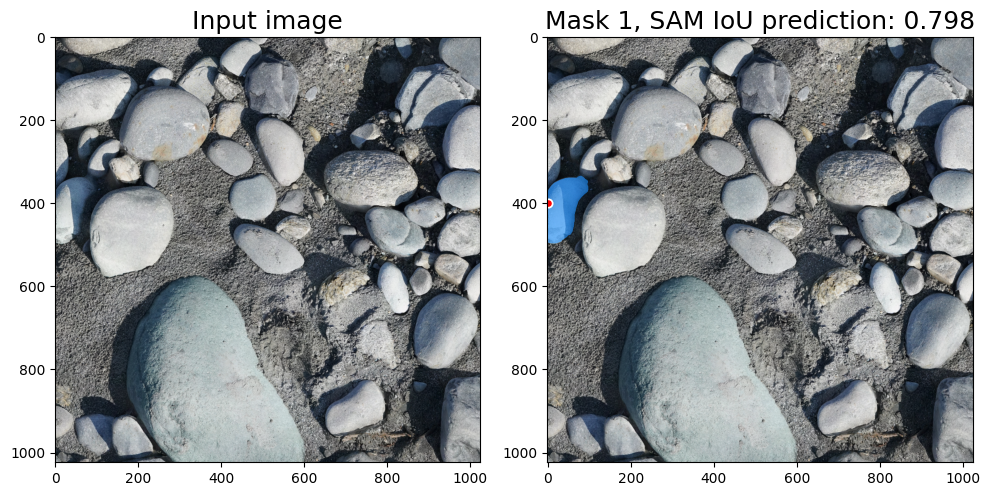

In [39]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', edgecolor='white', linewidth=1.25)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)   

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(temp_image)
plt.title('Input image', fontsize=18)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(2,2,i+2)
    plt.imshow(temp_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.title(f"Mask {i+1}, SAM IoU prediction: {score:.3f}", fontsize=18)
plt.tight_layout()
plt.show()  

In [ ]:
input_point = np.array([[853, 512]])
#input_point = np.array([[0, 400]])
input_label = np.array([1])

predictor = SamPredictor(sam)
predictor.set_image(temp_image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


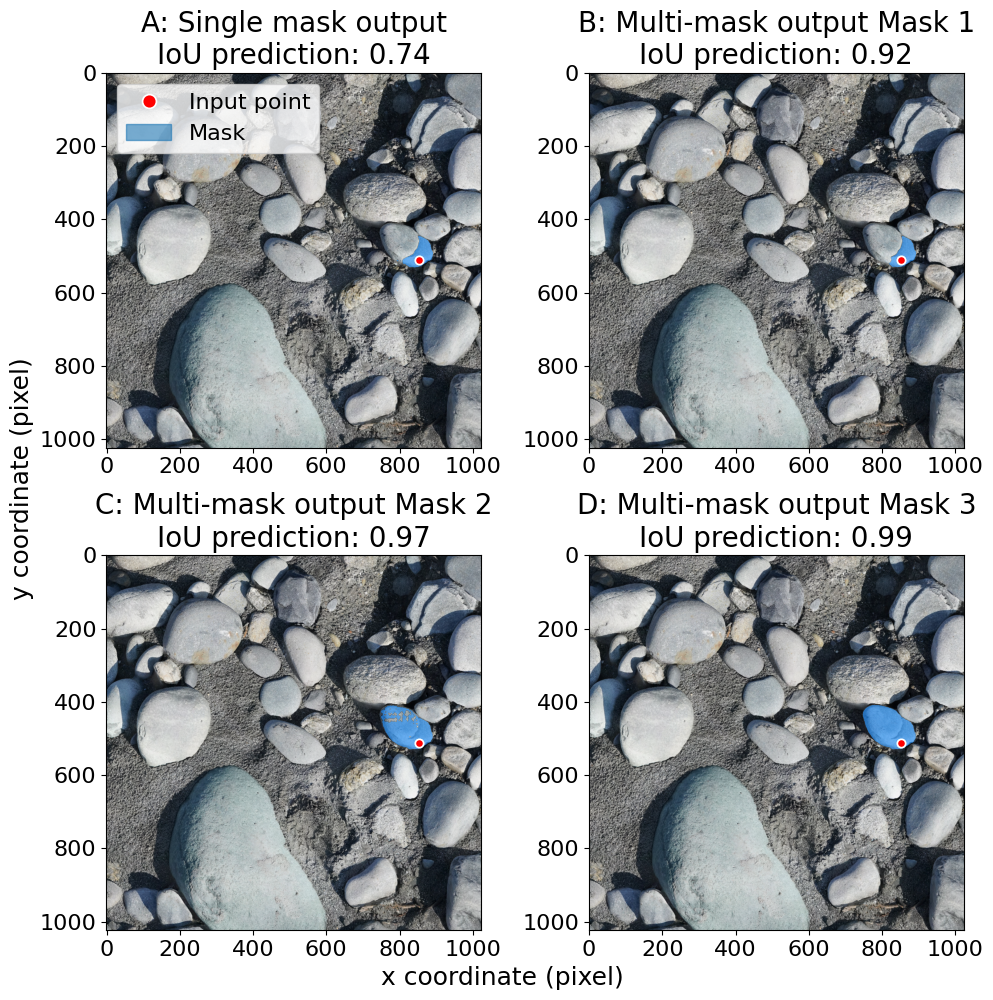

In [43]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', edgecolor='white', linewidth=1.25)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)   
import matplotlib.patches as mpatches

scatter_legend = plt.Line2D(
    [0], [0], 
    marker='o', color='red', markersize=10, markeredgecolor='white', 
    markeredgewidth=1.25, linestyle='None', label='Input point'
)

mask_legend = mpatches.Patch(
    color='tab:blue', alpha=0.6, label='Mask'
)


input_point = np.array([[853, 512]])
#input_point = np.array([[0, 400]])
input_label = np.array([1])

predictor = SamPredictor(sam)
predictor.set_image(temp_image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(temp_image)
show_mask(masks[0], plt.gca())
show_points(input_point, input_label, plt.gca())

scatter_legend = plt.Line2D(
    [0], [0], 
    marker='o', color='red', markersize=10, markeredgecolor='white', 
    markeredgewidth=1.25, linestyle='None', label='Input point'
)

mask_legend = mpatches.Patch(
    color='tab:blue', alpha=0.6, label='Mask'
)

plt.legend(handles=[scatter_legend, mask_legend], fontsize=16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(f'A: Single mask output\nIoU prediction: {scores[0]:.2f}', fontsize=20)
title=['B: ','C: ','D: ']

predictor = SamPredictor(sam)
predictor.set_image(temp_image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(2,2,i+2)
    plt.imshow(temp_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title[i]+f"Multi-mask output Mask {i+1}\nIoU prediction: {score:.2f}", fontsize=20)
plt.figtext(0.5, 0.01, 'x coordinate (pixel)', ha='center', fontsize=18)
plt.figtext(0.02, 0.4, 'y coordinate (pixel)', rotation=90, ha='center', fontsize=18)
plt.tight_layout(rect=[0.02,0.02,1,1])
plt.savefig('/DATA/vito/fig/3_mask_example')
plt.show()  